In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_y_exp
from bo_functions import create_y_data
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_ei_basic
from bo_functions import eval_GP_basic_tot
from bo_functions import create_sse_data

from bo_plotters import plot_hyperparams
from bo_plotters import plot_xy
from bo_plotters import y_plotter
from bo_plotters import stdev_plotter
from bo_plotters import ei_plotter

In [2]:
#Pull x data from CSV
Theta_True = np.array([1,-1])
noise_std = 0.1**2
q = 2

exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])
# print(train_sse)

In [4]:
#Reduce Number of Training Points
t =len(train_T) #Desired number of training points
# t = 10 #Set t=5 to show changing EI
train_T = train_T[0:t]
train_sse = train_sse[0:t]

In [5]:
#Define GP Testing space
#Define Testing Space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]
# print(theta_mesh)

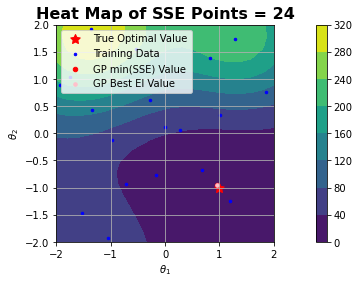

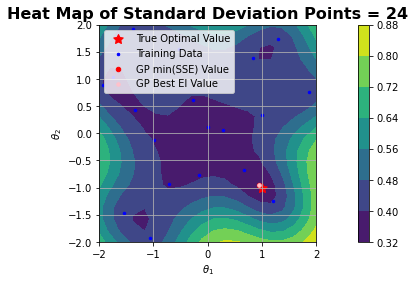

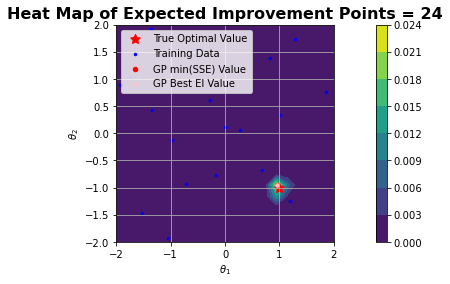

Number of iterations:  1
The SSE at the GP mean is lowest at Theta = [ 0.94736842 -0.94736842]
The GP estimates the highest EI is at Theta =  [ 0.94736842 -0.94736842]


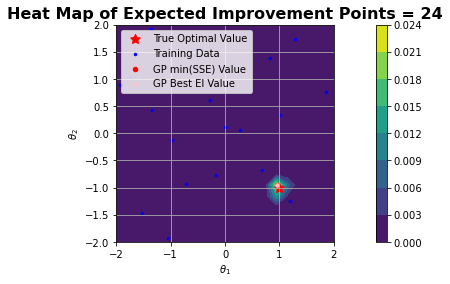

At iteration  1 the GP mean is  [0.51302507] and the GP variance is [0.11515366]


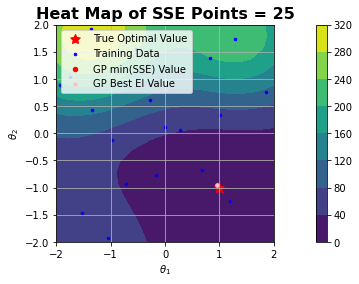

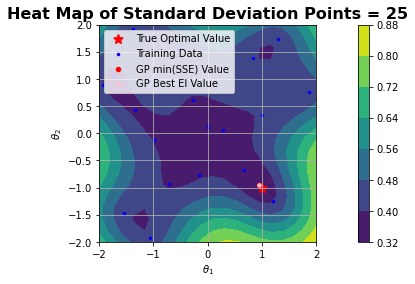

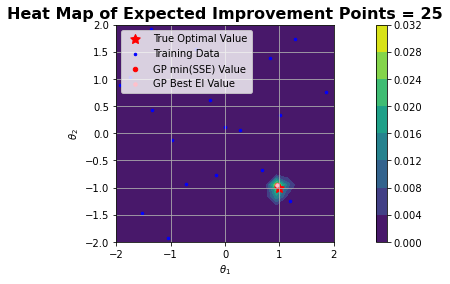

Number of iterations:  2
The SSE at the GP mean is lowest at Theta = [ 0.94736842 -0.94736842]
The GP estimates the highest EI is at Theta =  [ 0.94736842 -0.94736842]


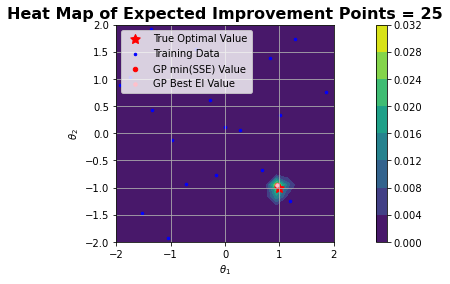

At iteration  2 the GP mean is  [0.46239892] and the GP variance is [0.11315951]


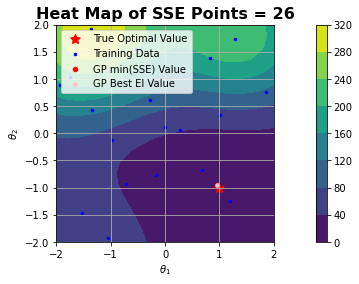

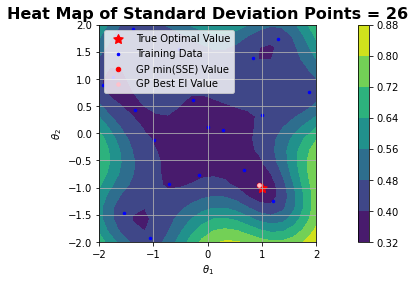

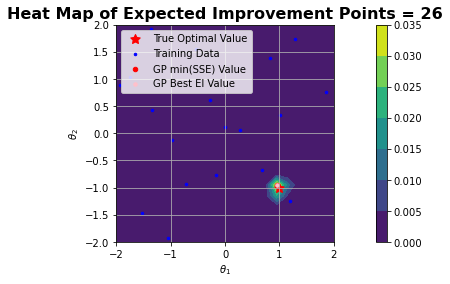

Number of iterations:  3
The SSE at the GP mean is lowest at Theta = [ 0.94736842 -0.94736842]
The GP estimates the highest EI is at Theta =  [ 0.94736842 -0.94736842]


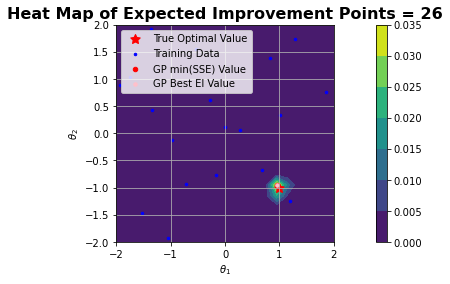

At iteration  3 the GP mean is  [0.42354773] and the GP variance is [0.11162917]


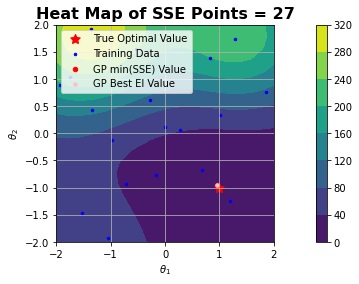

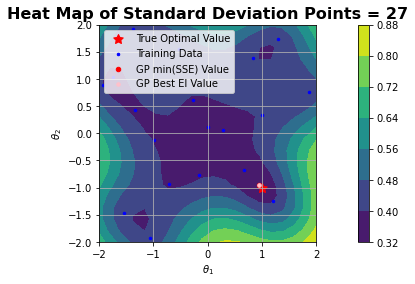

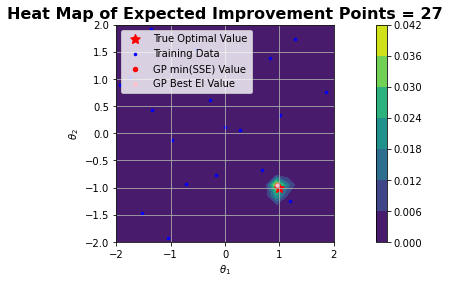

Number of iterations:  4
The SSE at the GP mean is lowest at Theta = [ 0.94736842 -0.94736842]
The GP estimates the highest EI is at Theta =  [ 0.94736842 -0.94736842]


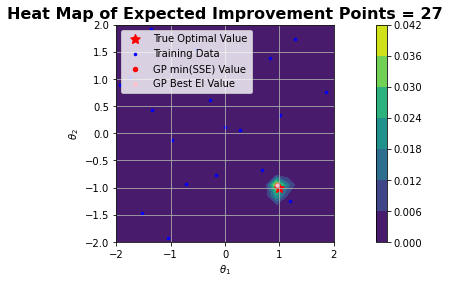

At iteration  4 the GP mean is  [0.39279142] and the GP variance is [0.11041768]


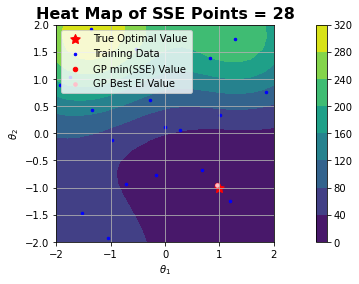

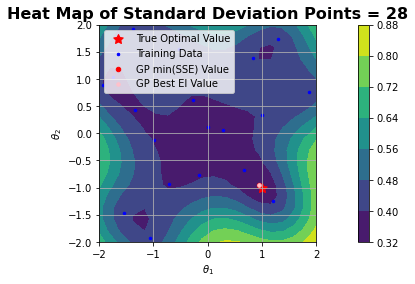

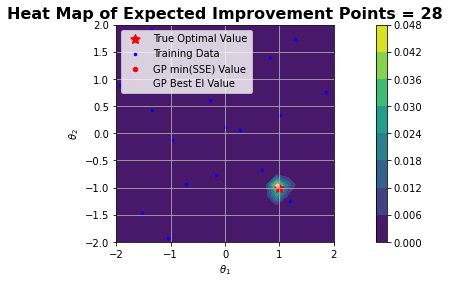

Number of iterations:  5
The SSE at the GP mean is lowest at Theta = [ 0.94736842 -0.94736842]
The GP estimates the highest EI is at Theta =  [ 0.94736842 -0.94736842]


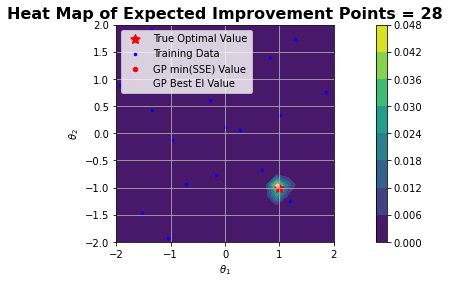

At iteration  5 the GP mean is  [0.36783876] and the GP variance is [0.10943479]


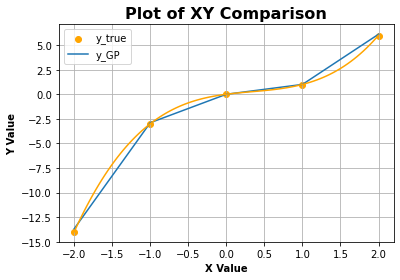

In [7]:
#Training the GP Model
iterations = 300
BO_iter = 5
for i in range(BO_iter):
    if torch.is_tensor(train_T) != True:
        train_T = torch.from_numpy(train_T)
    if torch.is_tensor(train_sse) != True:
        train_sse = torch.from_numpy(train_sse)
    # initialize likelihood and model
    ##Assumes a homoskedastic noise model p(y | f) = f + noise
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_T, train_sse, likelihood)
    train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
    

    
#     #Plot hyperparameters vs iteration
#     noise_title = "Noise Hyperparameter"
#     lengthscale_title = "Lengthscale Hyperparameter"
#     outputscale_title = "Outputscale Hyperparameter"
    
#     noise_list = train_GP[0]
#     lengthscale_list = train_GP[1]
#     outputscale_list = train_GP[2]
    
#     plot_hyperparams(iterations, noise_list,noise_title)
#     plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
#     plot_hyperparams(iterations, outputscale_list,outputscale_title)
    
    ##Set Hyperparameters to 1
    outputscale = torch.tensor([1])
    lengthscale = torch.tensor([1])
    noise = torch.tensor([0.1])

    model.likelihood.noise = noise
    model.covar_module.base_kernel.lengthscale =lengthscale
    model.covar_module.outputscale = outputscale

#     print("Noise Hyperparameter: ", float(model.likelihood.noise))
#     print("Lengthscale Hyperparameter: ", float(model.covar_module.base_kernel.lengthscale))
#     print("Outputscale Hyperparameter: ", float(model.covar_module.outputscale))

    
    model.eval()
    #Puts likelihood in evaluation mode
    likelihood.eval()

    #Same point keeps being selected, should I remove that point by force?
    ei_components = eval_GP_basic_tot(p,theta_mesh, train_sse, model, likelihood)
    ei = ei_components[0]
    sse = ei_components[1]
    var = ei_components[2]
    stdev = ei_components[3]
#     print(sse)

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    argmin = np.array(np.where(np.isclose(sse, np.amin(sse),atol=1e-10)==True))
    Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
    Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
    Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))
#     print(Theta_Opt_GP)
    #calculates best theta value
    argmax = np.array(np.where(np.isclose(ei, np.amax(ei),atol=1e-10)==True))
#     print(argmax)
    if len(argmax[0]) != 1:
        argmax = np.array([[argmax[0,1]],[argmax[1,1]]])
#         print(argmax)
    Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
    Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
    Theta_Best = np.array((Theta_1_Best,Theta_2_Best))    

    Converge = np.allclose(Theta_Best, train_T[-1],atol=1e-10)
    if Converge == True or i==BO_iter-1:
        #Make Plots
        sse_title = "SSE"
        y_plotter(theta_mesh, sse, Theta_True, Theta_Opt_GP, Theta_Best, train_T,sse_title,plot_train=True)
        stdev_plotter(theta_mesh, stdev,Theta_True, Theta_Opt_GP, Theta_Best, train_T,plot_train=True)
        ei_plotter(theta_mesh, ei, Theta_True, Theta_Opt_GP, Theta_Best,train_T,plot_train=True)
        print("Number of iterations: ", i+1)
        print("The SSE at the GP mean is lowest at Theta =",Theta_Opt_GP)
        print("The GP estimates the highest EI is at Theta = ",Theta_Best)    
        
        GP_mean = sse[argmin[0],argmin[1]]
        GP_var = (stdev[argmin[0],argmin[1]])**2
#         print("At iteration ",i+1,"the GP mean is ", GP_mean, "and the GP variance is", GP_var)
#         break

#     print(len(Theta_Best),len(Theta_True),len(Theta_Opt_GP))
#     sse_title = "SSE"
#     y_plotter(theta_mesh, sse, Theta_True, Theta_Opt_GP, Theta_Best, train_T,sse_title,plot_train=True)
#     stdev_plotter(theta_mesh, stdev,Theta_True, Theta_Opt_GP, Theta_Best, train_T,plot_train=True)
    ei_plotter(theta_mesh, ei, Theta_True, Theta_Opt_GP, Theta_Best,train_T,plot_train=True)
#     print("The SSE at the GP mean is lowest at Theta =",Theta_Opt_GP)
#     print("The GP estimates the highest EI is at Theta = ",Theta_Best)
    GP_mean = sse[argmin[0],argmin[1]]
    GP_var = (stdev[argmin[0],argmin[1]])**2
    print("At iteration ",i+1,"the GP mean is ", GP_mean, "and the GP variance is", GP_var)
    
    ##Append best values to training data 
    #Convert training data to numpy arrays to allow concatenation to work
    train_T = train_T.numpy() #(q x t)
    train_sse = train_sse.numpy() #(1 x t)

    #Call the expensive function and evaluate at Theta_Best
    sse_Best = create_sse_data(q,Theta_Best, Xexp, Yexp) #(1 x 1)
  
    #Add Theta_Best to train_p and y_best to train_y
    train_T = np.concatenate((train_T, [Theta_Best]), axis=0) #(q x t)
    train_sse = np.concatenate((train_sse, [sse_Best]),axis=0) #(1 x t)
    
q_y = 3
y_GP_input = np.zeros((n,3))
for j in range(n):
    y_GP_input[j] = np.array([Theta_Best[0],Theta_Best[1],Xexp[j]])

y_GP_Opt = create_y_data(q_y,y_GP_input)

title = "XY Comparison"
plot_xy(Xexp, Yexp, y_GP_Opt,Theta_True,title)